# Data Extraction and cleaning

- get data from restricted folder


In [4]:
# pip install python-calamine
import pandas as pd
from pathlib import Path
from sklearn import preprocessing 
import plotly.graph_objects as go
label_encoder = preprocessing.LabelEncoder()

In [5]:
ts = dict()
DATAFOLDER = Path('restricted/yearend/')
filenames = [f for f in DATAFOLDER.glob('FY*.xlsx')]

for fn in filenames:
    fy = fn.name[:4]
    print(f"{fy}+++++++++++++++++++++")
    df = pd.read_excel(fn, sheet_name='Sheet1', skiprows=0, engine='calamine')
    df.rename(
        columns={'BU Segment': 'BUSegment', "SO number":"AKZ", "Customer CN Name": "CustomerChineseName"}, 
        inplace=True)
    print('rows in df:', len(df))
    df = df.loc[df.BUSegment.fillna('').str.contains('FA Product')]
    print('rows in df (filtered "FA Product"):', len(df))
    cols = ['PostDate', 'AKZ', 'Territory', 'GBK', 'VBEZ', 'CompanyName',
            'CustomerChineseName', 'AssignedCustomerType', 'AssignedCustomerName', 'AssignType']
    grp = df.groupby(cols)[['OR', 'TO']].sum().reset_index()
    print('grouped rows:', len(grp))
    grp = grp.loc[(grp[['OR', 'TO']]!=0).any(axis=1)]
    print('grouped rows without all Zero:', len(grp))
    grp['PostDate'] = pd.to_datetime(grp.PostDate)
    ts[fy] = grp
ts = pd.concat(ts.values(), keys=ts.keys()).droplevel(-1).reset_index()
ts

FY18+++++++++++++++++++++
rows in df: 35956
rows in df (filtered "FA Product"): 12859
grouped rows: 5370
grouped rows without all Zero: 5370
FY19+++++++++++++++++++++
rows in df: 37570
rows in df (filtered "FA Product"): 13977
grouped rows: 6840
grouped rows without all Zero: 6826
FY20+++++++++++++++++++++
rows in df: 53193
rows in df (filtered "FA Product"): 24172
grouped rows: 13804
grouped rows without all Zero: 13781
FY21+++++++++++++++++++++
rows in df: 61237
rows in df (filtered "FA Product"): 28302
grouped rows: 15805
grouped rows without all Zero: 15781
FY22+++++++++++++++++++++
rows in df: 94512
rows in df (filtered "FA Product"): 51299
grouped rows: 19975
grouped rows without all Zero: 19853
FY23+++++++++++++++++++++
rows in df: 121717
rows in df (filtered "FA Product"): 49609
grouped rows: 46591
grouped rows without all Zero: 38860
FY24+++++++++++++++++++++
rows in df: 39599
rows in df (filtered "FA Product"): 12893
grouped rows: 12480
grouped rows without all Zero: 10630


,index,PostDate,AKZ,Territory,GBK,VBEZ,CompanyName,CustomerChineseName,AssignedCustomerType,AssignedCustomerName,AssignType,OR,TO
0,FY18,2017-10-31,3004120993,RNE-LNN&IME,R115,200TM000,SLC,北京天拓四方科技有限公司,System Integrator/VA Partner,沈阳紫电科技有限公司,Assign_TO,74629.79,74629.79
1,FY18,2017-10-31,3004125453,RNE-JL,R115,22012004,SLC,哈尔滨宇龙自动化有限公司,System Integrator/VA Partner,长春北方化工罐装设备有限公司,Assign_TO,23405.08,23405.08
2,FY18,2017-10-31,3004131929,RNE-HLJ,R111,21009006,SLC,哈尔滨宇龙自动化有限公司,System Integrator/VA Partner,哈尔滨天源自动化控制技术有限责任公司,Assign_TO,15310.63,15310.63
3,FY18,2017-10-31,3004131929,RNE-JL,R111,22012004,SLC,哈尔滨宇龙自动化有限公司,System Integrator/VA Partner,长春北方化工罐装设备有限公司,Assign_TO,2841.88,2841.88
4,FY18,2017-10-31,3004133247,RNE-HLJ,R111,22009005,SLC,哈尔滨宇龙自动化有限公司,OEM,哈尔滨研奥科技有限公司,Assign_TO,4702.64,4702.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111096,FY24,2024-04-08,3008936966,RNE-LNN&IME,R152,2V1A04K2,SLC,华晨宝马汽车有限公司,End-Customer,华晨宝马汽车有限公司,Direct,4791.61,0.00
111097,FY24,2024-04-08,3008993790,RNE-LNN&IME,R132,2V1A04K2,SLC,华晨宝马汽车有限公司,End-Customer,华晨宝马汽车有限公司,Direct,808.10,0.00
111098,FY24,2024-04-08,3009011257,RNE-LNS,R141,2PPDT900,SLC,大连四星电子技术开发有限公司,-,大连四星电子技术开发有限公司,Direct,10457.53,0.00
111099,FY24,2024-04-08,3009011257,RNE-LNS,R151,2PPDT900,SLC,大连四星电子技术开发有限公司,-,大连四星电子技术开发有限公司,Direct,27100.75,0.00


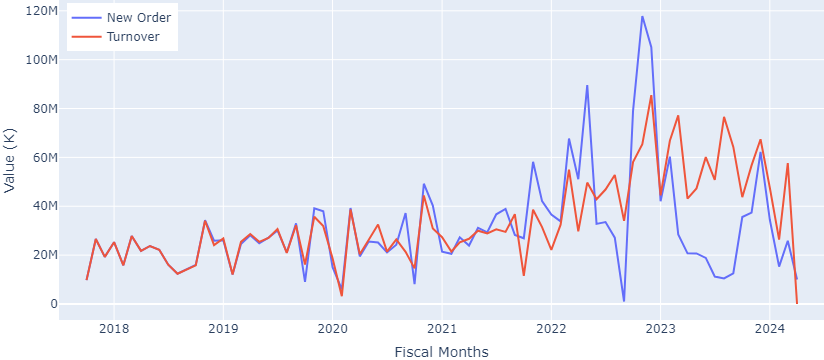

In [13]:
ts['month'] = ts['PostDate'].dt.strftime('%Y-%m')

order = ts.groupby('month')['OR'].sum()
turnover = ts.groupby('month')['TO'].sum()

plot_order = go.Scatter(x=order.index, y=order, mode='lines', name='New Order')
plot_turnover = go.Scatter(x=turnover.index, y=turnover, mode='lines', name='Turnover')

fig = go.Figure([plot_order, plot_turnover])
fig.update_layout(
    height=680, margin={'t':0, 'b':0, 'l':0, 'r':0},
    xaxis=dict(title="Fiscal Months", dtick='M12', range=['2017-07-01','2024-06-30']),
    yaxis=dict(title="Value (K)"),
    legend=dict(x=0.01, y=0.99)
)
fig.show()

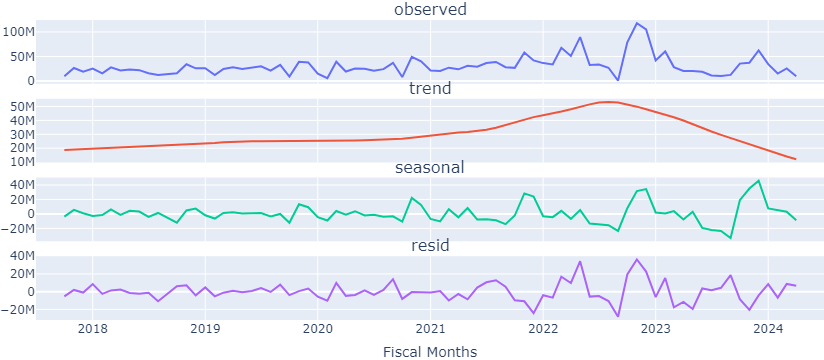

In [14]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose, STL
decomposition = STL(order, period=12).fit()

fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=['observed', 'trend', 'seasonal', 'resid']
)

x = order.index
fig.add_trace(go.Scatter(x=x, y=decomposition.observed), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=decomposition.trend), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=decomposition.seasonal), row=3, col=1)
fig.add_trace(go.Scatter(x=x, y=decomposition.resid), row=4, col=1)

fig.update_layout(
    height=1200, margin={'t':20, 'b':0, 'l':0, 'r':0},
    xaxis4=dict(title="Fiscal Months", dtick='M12', range=['2017-07-01','2024-06-30']),
    showlegend=False
)
fig.show()

In [15]:
ts['BuyerType'] = 'Dealer'
ts.loc[ts.AssignedCustomerType.astype(str).str.contains('End'), 'BuyerType'] = 'End-User'
ts.loc[ts.AssignedCustomerType.astype(str).str.contains('OEM'), 'BuyerType'] = 'OEM'

# Encodeding restricted Columns
# lab_cols = ['AKZ', 'Territory', 'VBEZ', 'GBK', 'CustomerChineseName', 'AssignedCustomerName']
# for col in lab_cols:
#     ts[col] = label_encoder.fit_transform(ts[col])
#     ts[col] = ts[col].apply(lambda x: col[:3].upper()+f"{x:08}")
    
ts.rename(columns={
    'index':'FiscalYear',
    'AKZ':'OrderNum',
    'GBK':'ProductLine',
    'VBEZ':'Sales',
    'CustomerChineseName':'Buyer',
    'AssignedCustomerName':'AssignedCustomer',
    'CompanyName': 'channel'
    }, inplace=True)

cols = ['PostDate', 'month', 'FiscalYear', 'AssignType', 'channel', 'BuyerType', 'OrderNum', 'ProductLine', 'Territory', 'Sales', 'Buyer', 'AssignedCustomer', 'OR', 'TO']
ts[cols]

,PostDate,month,FiscalYear,AssignType,channel,BuyerType,OrderNum,ProductLine,Territory,Sales,Buyer,AssignedCustomer,OR,TO
0,2017-10-31,2017-10,FY18,Assign_TO,SLC,Dealer,3004120993,R115,RNE-LNN&IME,200TM000,北京天拓四方科技有限公司,沈阳紫电科技有限公司,74629.79,74629.79
1,2017-10-31,2017-10,FY18,Assign_TO,SLC,Dealer,3004125453,R115,RNE-JL,22012004,哈尔滨宇龙自动化有限公司,长春北方化工罐装设备有限公司,23405.08,23405.08
2,2017-10-31,2017-10,FY18,Assign_TO,SLC,Dealer,3004131929,R111,RNE-HLJ,21009006,哈尔滨宇龙自动化有限公司,哈尔滨天源自动化控制技术有限责任公司,15310.63,15310.63
3,2017-10-31,2017-10,FY18,Assign_TO,SLC,Dealer,3004131929,R111,RNE-JL,22012004,哈尔滨宇龙自动化有限公司,长春北方化工罐装设备有限公司,2841.88,2841.88
4,2017-10-31,2017-10,FY18,Assign_TO,SLC,OEM,3004133247,R111,RNE-HLJ,22009005,哈尔滨宇龙自动化有限公司,哈尔滨研奥科技有限公司,4702.64,4702.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111096,2024-04-08,2024-04,FY24,Direct,SLC,End-User,3008936966,R152,RNE-LNN&IME,2V1A04K2,华晨宝马汽车有限公司,华晨宝马汽车有限公司,4791.61,0.00
111097,2024-04-08,2024-04,FY24,Direct,SLC,End-User,3008993790,R132,RNE-LNN&IME,2V1A04K2,华晨宝马汽车有限公司,华晨宝马汽车有限公司,808.10,0.00
111098,2024-04-08,2024-04,FY24,Direct,SLC,Dealer,3009011257,R141,RNE-LNS,2PPDT900,大连四星电子技术开发有限公司,大连四星电子技术开发有限公司,10457.53,0.00
111099,2024-04-08,2024-04,FY24,Direct,SLC,Dealer,3009011257,R151,RNE-LNS,2PPDT900,大连四星电子技术开发有限公司,大连四星电子技术开发有限公司,27100.75,0.00


In [16]:
ts[cols].to_csv('data/orders.csv', index=False)